# vdl Depth and Class Constrained Diffusion
- **Name:** Nils Fahrni
- **Date:** 07.01.2025

## Dataset Preparation
Ensuring that the dataset is structured for the task:

- Images of rooms (RGB images).
- Segmentation masks (label maps identifying furniture and objects).
- Depth maps (grayscale indicating depth).

For every image in your dataset:

Preprocess the depth maps: Compute average depth for each segmented furniture piece using the segmentation mask.

For object $o$: $avg\_depth(o) =  \frac{\sum_{p\in mask(o)} depth(p)}{count(mask(o))}$
 
Save these average depths along with their respective segmentation masks and image.

In [33]:
import h5py
import numpy as np
from torchvision import transforms
from PIL import Image
import os

BASE_DATA_PATH = 'data/'

# load the .mat file

data = h5py.File(BASE_DATA_PATH + 'nyu_depth_v2_labeled.mat', 'r')

first_n = 1

images = data['images'][:first_n]
segments = data['labels'][:first_n]
depths = data['depths'][:first_n]

image_transform = transforms.Compose([
    transforms.CenterCrop(400),
    transforms.Resize(64),
    transforms.ToTensor(),
    #transforms.Normalize((1.3268, 1.1391, 1.0176), (0.5704, 0.5411, 0.5077))
])

crop_transform = transforms.Compose([
    transforms.CenterCrop(400),
    transforms.Resize(64, interpolation=Image.NEAREST),
    transforms.ToTensor()
])

def save_image(image, id, output_dir):
    img_pil = transforms.ToPILImage()(image)
    img_path = os.path.join(output_dir, f"image_{id}.png")
    img_pil.save(img_path)

images_dir = "processed_data/images"
os.makedirs(images_dir, exist_ok=True)

seg_masks_dir = "processed_data/seg_masks"
os.makedirs(seg_masks_dir, exist_ok=True)

depth_maps_dir = "processed_data/depth_maps"
os.makedirs(depth_maps_dir, exist_ok=True)

In [34]:
import matplotlib.pyplot as plt

for id, (img, seg, depth) in enumerate(zip(images, segments, depths)):
    # Ensure correct shape for images
    img = np.transpose(img, (2, 1, 0))  # Convert from (channels, height, width) to (height, width, channels)
    seg = np.transpose(seg)  # Ensure (height, width) for segmentation masks
    depth = np.transpose(depth)  # Ensure (height, width) for depth maps
    
    print(f'depth shape {depth.shape}')
    
    # Convert to PIL images
    img = Image.fromarray(img, mode="RGB")
    seg = Image.fromarray(seg, mode="L")
    depth = Image.fromarray(depth)
    
    # plot the depth map
    print(np.unique(depth))

    # Apply transformations
    img = crop_transform(img)
    seg = crop_transform(seg)
    depth = crop_transform(depth)

    # Save images
    save_image(img, id, images_dir)
    save_image(seg, id, seg_masks_dir)
    save_image(depth, id, depth_maps_dir)

    print(img.shape, seg.shape, depth.shape)

depth shape (480, 640)
[1.7985953 1.7991675 1.8000963 ... 3.606224  3.614007  3.615639 ]
torch.Size([3, 64, 64]) torch.Size([1, 64, 64]) torch.Size([1, 64, 64])


In [1]:
from data.nyuv2 import NYUDepthV2
from torchvision import transforms
from torch.utils.data import DataLoader

t = transforms.Compose([
    transforms.CenterCrop(400),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((1.3268, 1.1391, 1.0176), (0.5704, 0.5411, 0.5077))
])

dataset = NYUDepthV2(root='data', download=True, image_transform=t)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

Dataset already exists, skipping download.


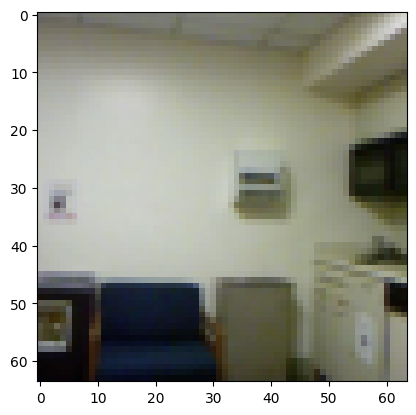

In [2]:
import torch
import matplotlib.pyplot as plt

def unnormalize(img):
    mean = torch.tensor([1.3268, 1.1391, 1.0176]).view(-1, 1, 1)  # Reshape to [C, 1, 1]
    std = torch.tensor([0.5704, 0.5411, 0.5077]).view(-1, 1, 1)    # Reshape to [C, 1, 1]
    img = std * img + mean
    img = torch.clip(img, 0, 1)
    return img

plt.imshow(unnormalize(dataset[0][0]).permute(1, 2, 0))

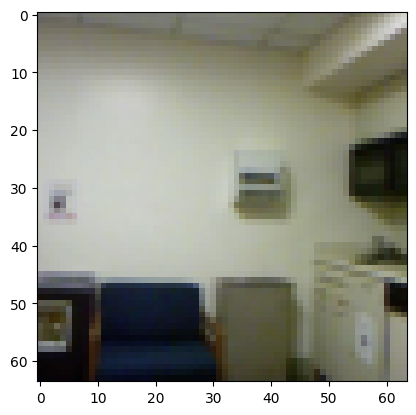

In [3]:
# images

plt.imshow(unnormalize(dataset[0][0]).permute(1,2,0))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

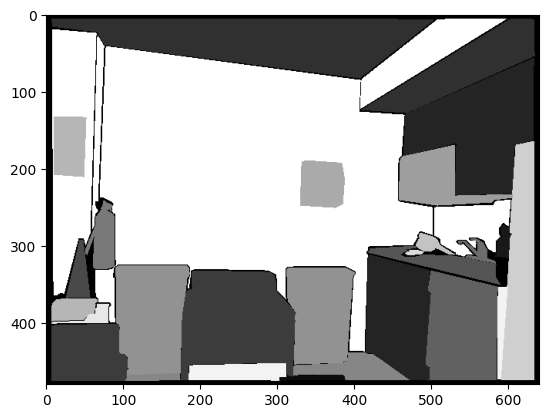

In [4]:
# seg masks

plt.imshow(dataset[0][1], cmap='gray')

dataset[0][1]

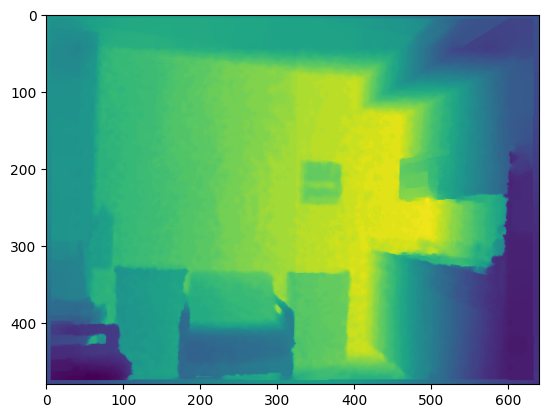

In [5]:
# depth maps

plt.imshow(dataset[0][2])

## Conditioning Signals

To allow conditioning on specific depth and furniture configurations:

- Encode depth constraints: Use the average depth values for each furniture class as part of your conditioning vector.
- Encode class constraints: Use the segmentation mask labels for furniture as an additional conditioning signal.

These conditioning signals could be combined into a vector:

- One-hot encode the furniture classes.
- Concatenate them with normalized average depth values.

## Define Diffusion Architecture

Add Conditioning Mechanisms:

Use FiLM layers (Feature-wise Linear Modulation) to condition the intermediate feature maps in your U-Net with the conditioning vector.
FiLM applies scale and shift:
$$FiLM(x)=\gamma \cdot x+\Beta$$
where
$\gamma$ and $\Beta$ are computed from the conditioning vector using small fully connected networks.

Input Features:
- Concatenate the segmentation mask and depth map with the input image as additional channels to the U-Net.
- Input dimensions: $(image + segmentation mask + depth map) \times width \times height$

## Diffusion Process
The diffusion process typically works by corrupting an image through adding noise over $T$ timesteps and learning to denoise it step-by-step.

Forward Process:

- Use the segmentation mask, depth map, and conditioning vector to guide the corruption process.

Reverse Process:

- During denoising, inject the conditioning vector at each timestep to guide the diffusion toward the desired scene.

## Loss Function
Use a standard denoising diffusion loss, but augment it with terms that enforce depth and segmentation accuracy:

- Pixel-wise Reconstruction Loss: Match the generated and ground truth images.
- Depth Consistency Loss: Compute the difference between the generated depth and the conditioned depth.

$$\mathcal{L}_\text{depth}=||\text{avg\_depth}_{\text{gen}}-\text{avg\_depth}_{\text{cond}}||_2$$
 
- Segmentation Consistency Loss: Enforce similarity between generated and conditioned segmentation masks (e.g., with CrossEntropy or Dice Loss).

## Training Process
Train the U-Net on the corrupted images to predict denoised images conditioned on the depth and segmentation data.
Augment your dataset by introducing slight random perturbations in the depth values during training for robustness.

## Sampling
To generate new scenes:

Start with a noisy image.
Provide a conditioning vector specifying the desired furniture configuration and depths.
Iteratively denoise the image using the reverse process of the diffusion model, injecting the conditioning vector at each timestep.


## Optional Enhancements
Attention Mechanisms: Add attention blocks (e.g., cross-attention) to enable fine-grained control over depth and segmentation.
Classifier-Free Guidance: Train the model with and without conditioning and use classifier-free guidance to bias the generation process towards the conditioning.